# AI coursework


using the mush.csv dataset.
we will do binary classification with the three algorithms

- tree decision thing
- logistic regression
- k nearest thing


## Used Libraries

In [110]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import scipy as sc
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt


In [111]:
dataset = pd.read_csv('./mush.csv')
print("train set : ", dataset.shape)

train set :  (8416, 23)


Now that we have imported the (extended) dataset into the Pandas Dataframe `dataset` we can do some EDA
# Exploratory Data Analysis 

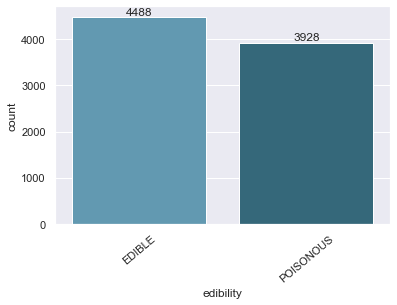

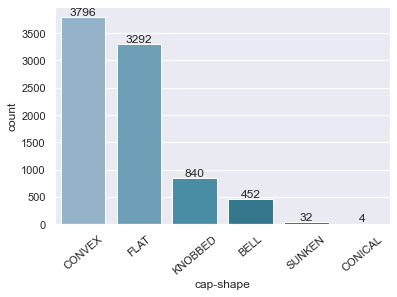

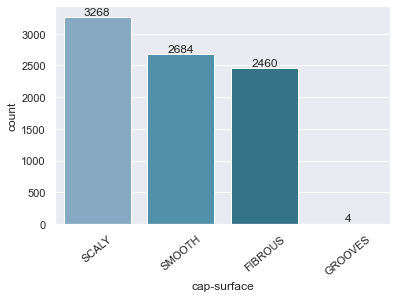

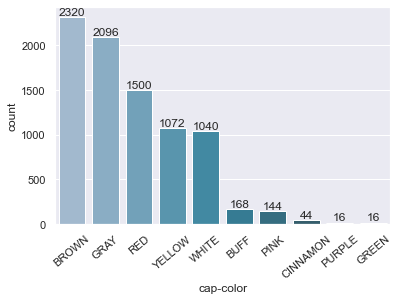

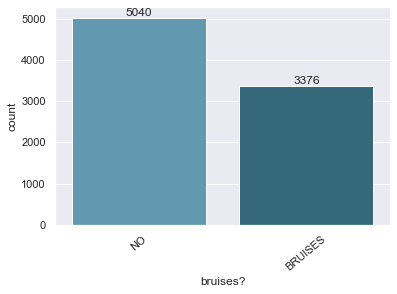

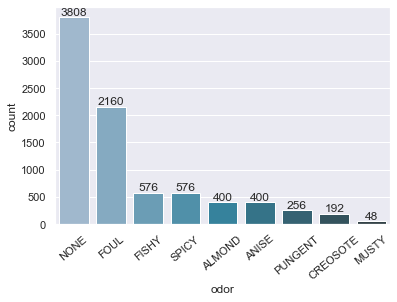

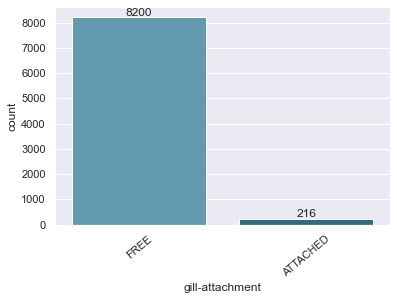

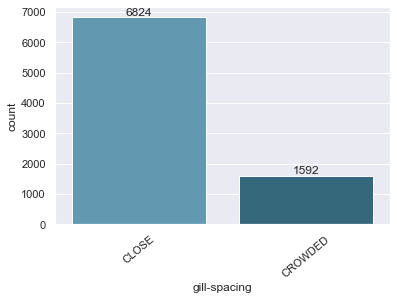

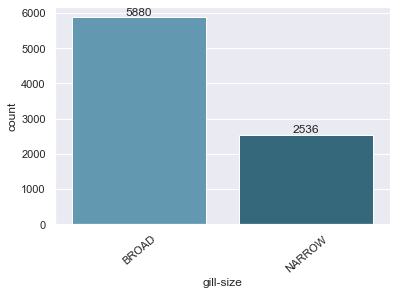

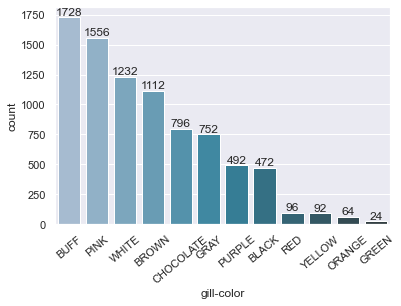

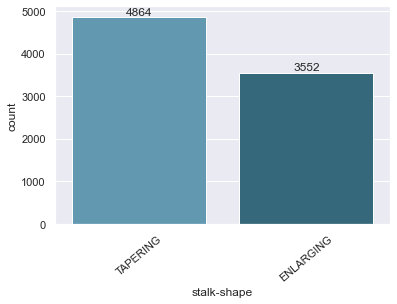

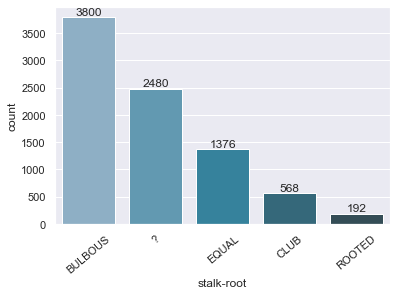

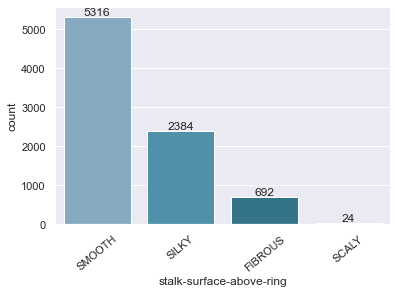

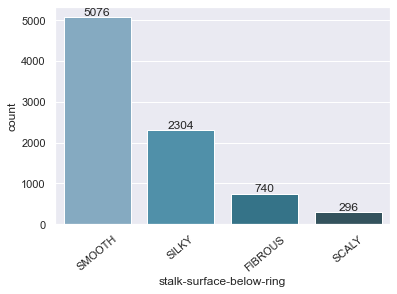

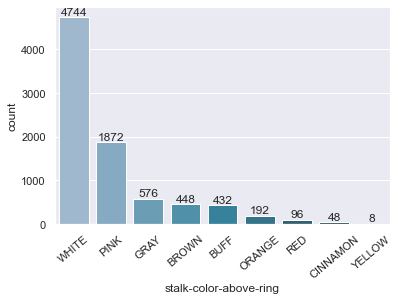

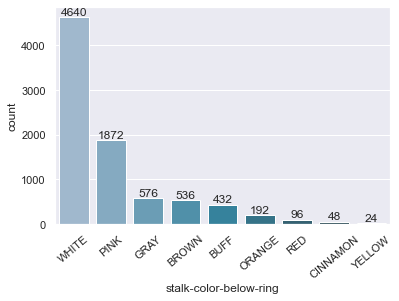

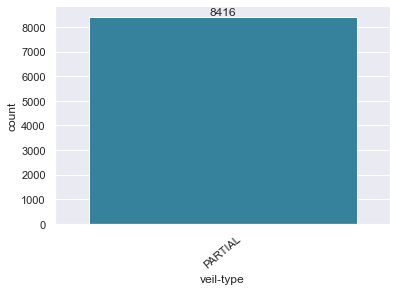

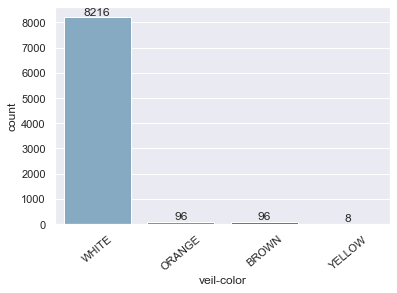

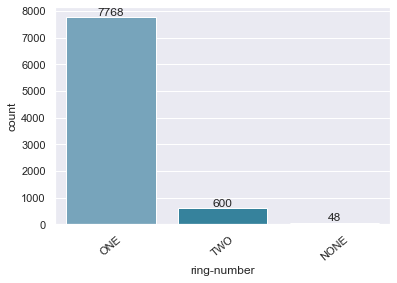

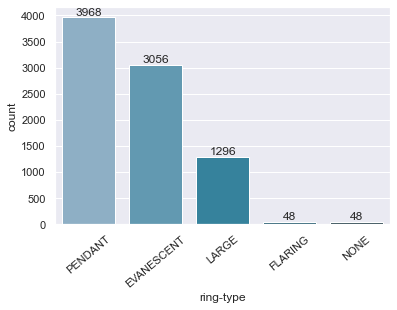

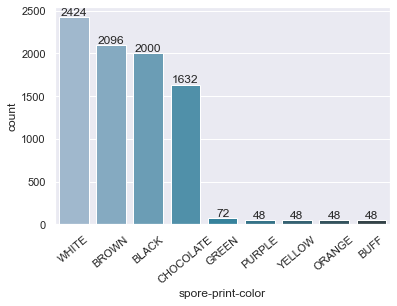

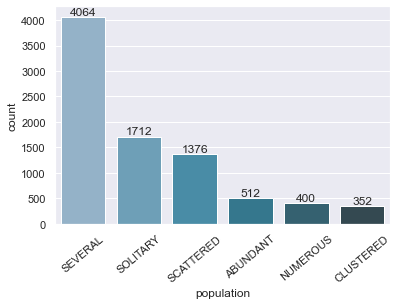

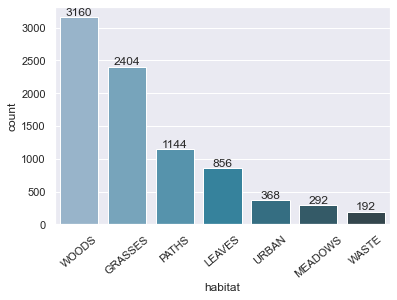

In [112]:
columns = dataset.columns
for col in columns:
    #series = dataset[col].value_counts()
    #print(series)
    #print("null values = " + str(dataset[col].isnull().sum()))
    #print("\n")
    
    sns.set_theme()
    plot = sns.countplot(x=dataset[col], order=dataset[col].value_counts(ascending=False).index, palette = "PuBuGn_d");
    
    
    abs_values = dataset[col].value_counts(ascending=False)
    lbls = [f'{p[0]}' for p in zip(abs_values)]
    plot.bar_label(container=plot.containers[0], labels=lbls)
    
    plot.set_xticklabels(plot.get_xticklabels(), rotation=40)

    plt.show()
    if col == "bruises?":
        col = "bruises"
    
    # To save new copies of the attribute Bar charts
    # plot.figure.savefig("Graphs/"+col+".png", bbox_inches='tight')
    
    

If we go through, we can see that attribute #16 'veil-type' is a useless attribute since all $8416$ rows have the same value. So, we can remove this column since it will do nothing but take up time. Now, we are down to 22 columns (including the `edibility` column)

In [113]:
dataset = dataset.drop(['veil-type'], axis = 1)

Here we have printed out the the sums of all the values in each column, as well as a count of the number of null values in each. 
Since the null values in attribute $#11$ are represented by the string `'?'`, they are not registered as a null value by pandas.

In [114]:
dataset = dataset.replace("?", np.NaN)
dataset.isnull().sum()

edibility                      0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises?                       0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

Now that the missing values have been correctly replaced with the Pandas `NaN` indicator, we can deal with thees datapoints how we see fit.


Two options would be to either delete the column with the missing data (`stalk-root` attribute $#11$) or delete the rows with the missing data

By deleting the Column with the missing data, we will still have $8416$ entries, and only $21$ columns to work with (including edibility)

On the other hand, by deleting the Rows with the missing values, we will keep $22$ columns but will go down to $5936$ columns

In [115]:
# To delete rows with missing data
# dataset.dropna(axis=0)

# To delete attribute #11
dataset = dataset.dropna(axis=1)
dataset.shape


(8416, 21)

Now that we have fixed up our dataset, we must now do some Data Transformation
# Data Transformation
all of our $22$ attributes can be divided into 3 categories; Ordinal, Nominal and Binary Nominal attributes

Binary Nominal Attributes with only two values only require one binary flag (0,1) to represent it's data.
- #0 'edibility': {'EDIBLE':1,'POISONOUS':0}
- #4 'bruises?' : {'BRUISES':1,'NO':0}
- #6 'gill-attachment' : {'FREE':0,'ATTACHED':1}
- #8 'gill-size' : {'BROAD':0,'NARROW':1}
- #10 'stalk-shape' : {'ENLARGING':0,'TAPERING':1}


Ordinal attributes can be use a mapping dictionary to map each category to an integer.
- #7 'gill-spacing' : {'CLOSE':0,'CROWDED':1,'DISTANT':2}
- #18 'ring-number' : {'NONE':0,'ONE':1,'TWO':2}
- #21 'population' : {'ABUNDANT':6,'CLUSTERED':5,'NUMEROUS':4,'SCATTERED':3,'SEVERAL':2,'SOLITARY':1}

And the rest are Nominal chategorical attributes so will likely have to be one-hot encoded




In [116]:
# Binary Nominal Attributes
edibility_map_dict = {"EDIBLE":1,"POISONOUS":0}
bruises_map_dict = {"BRUISES":1,"NO":0}
gill_attachment_map_dict = {"FREE":0,"ATTACHED":1}
gill_size_map_dict = {'BROAD':0,'NARROW':1}
stalk_shape_map_dict = {'ENLARGING':0,'TAPERING':1}
# Ordinal Attributes
gill_spacing_map_dict = {'CLOSE':0,'CROWDED':1,'DISTANT':2}
ring_number_map_dict = {'NONE':0,'ONE':1,'TWO':2}
population_map_dict = {'ABUNDANT':6,'CLUSTERED':5,'NUMEROUS':4,'SCATTERED':3,'SEVERAL':2,'SOLITARY':1}

mapping_dicts = [edibility_map_dict, bruises_map_dict, gill_attachment_map_dict, gill_size_map_dict, stalk_shape_map_dict, gill_spacing_map_dict, ring_number_map_dict, population_map_dict]
mapping_columns = ['edibility','bruises?','gill-attachment','gill-size','stalk-shape','gill-spacing','ring-number','population']

for i in range(len(mapping_columns)):
    dataset[mapping_columns[i]] = dataset[mapping_columns[i]].map(mapping_dicts[i])
    
onehot_columns = ['cap-shape','cap-surface','cap-color','odor','gill-color','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-color','ring-type','spore-print-color','habitat']
cleanDataset = pd.get_dummies(dataset, columns=onehot_columns)

Now, the dataset is cleaned, and stored in the new Pandas DF `cleanDataset`

In [117]:
cleanDataset.shape

(8416, 100)

In [118]:
cleanDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8416 entries, 0 to 8415
Data columns (total 100 columns):
 #   Column                            Non-Null Count  Dtype
---  ------                            --------------  -----
 0   edibility                         8416 non-null   int64
 1   bruises?                          8416 non-null   int64
 2   gill-attachment                   8416 non-null   int64
 3   gill-spacing                      8416 non-null   int64
 4   gill-size                         8416 non-null   int64
 5   stalk-shape                       8416 non-null   int64
 6   ring-number                       8416 non-null   int64
 7   population                        8416 non-null   int64
 8   cap-shape_BELL                    8416 non-null   uint8
 9   cap-shape_CONICAL                 8416 non-null   uint8
 10  cap-shape_CONVEX                  8416 non-null   uint8
 11  cap-shape_FLAT                    8416 non-null   uint8
 12  cap-shape_KNOBBED                

In [119]:
cleanDataset.describe()

,edibility,bruises?,gill-attachment,gill-spacing,gill-size,stalk-shape,ring-number,population,cap-shape_BELL,cap-shape_CONICAL,...,spore-print-color_PURPLE,spore-print-color_WHITE,spore-print-color_YELLOW,habitat_GRASSES,habitat_LEAVES,habitat_MEADOWS,habitat_PATHS,habitat_URBAN,habitat_WASTE,habitat_WOODS
count,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,...,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000,8416.000000
mean,0.533270,0.401141,0.025665,0.189163,0.301331,0.577947,1.065589,2.423954,0.053707,0.000475,...,0.005703,0.288023,0.005703,0.285646,0.101711,0.034696,0.135932,0.043726,0.022814,0.375475
std,0.498922,0.490159,0.158144,0.391662,0.458863,0.493916,0.269635,1.314272,0.225452,0.021797,...,0.075310,0.452869,0.075310,0.451749,0.302286,0.183019,0.342736,0.204497,0.149318,0.484274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now that all our data is clean, encoded and ready to go, lets get started by splitting the data up into all the relevant groups.

# Data Splitting

If we assume we will be using a simple data splitting method, we simply need to have both the $X$ and $y$ for training aand testing

In [129]:
y = cleanDataset['edibility'].values
X = cleanDataset.iloc[:, 1:].values
print("y: "+str(y.shape) + "\nX: "+str(X.shape))

y: (8416,)
X: (8416, 99)


Now we have the columns in their correct places, lets shuffle them around, and then split them into the correct Test and Train sets.
Note that the ratio of columns assigned to the train set and the test set can be changed by changing the variable `train_ratio` 

We have the version of the splitter to **stratify** the random splitting. This way the proportions of examples in both classes for y is maintained in both splits 

In [137]:
from sklearn.model_selection import train_test_split
train_ratio = 0.8


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = train_ratio, random_state = 0, stratify = y)
"""
indices = np.arange(cleanDataset.shape[0])
rng = np.random.RandomState(0)
permuted_indices = rng.permutation(indices)

train_size = round(train_ratio*cleanDataset.shape[0])
test_size = cleanDataset.shape[0] - train_size
print("train: "+str(train_size)+"\ntest: "+str(test_size))
train_ind = permuted_indices[:train_size]
test_ind = permuted_indices[train_size:]


X_train, X_test = X[train_ind], X[test_ind]
y_train, y_test = y[train_ind], y[test_ind]
"""


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1683, 99) (1683,)
(6733, 99) (6733,)


Now we have split the data into all the seperate parts. 
- `X_train`
- `X_test`
- `y_train`
- `y_test`

**note** that these can now be used for training and testing, although if any alterations happen during the datasets themselves, be sure to copy thees into a local variable so that in the end we are able to run all of the algorithms with one simple click